In [1]:
!pip install -U keras


     |████████████████████████████████| 378kB 3.4MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from math import sqrt

from keras.layers import Input, Dense, Embedding, LSTM, Activation, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MinMaxScaler


from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit

Using TensorFlow backend.


In [4]:
tf.__version__

'2.2.0-rc2'

In [0]:
#Run Local
#df = pd.read_csv("csv/book_info_complete.csv")
#Run on COLAB
df = pd.read_csv("/content/drive/My Drive/final_project/book_info_complete.csv")

In [6]:
df = df.dropna(axis=1)
df["Publication date"] = df["Publication date"].str[-4:].astype(int)
df = df.drop("Last updated", axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5816 entries, 0 to 5815
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   title             5816 non-null   object
 1   description       5816 non-null   object
 2   plot              5816 non-null   object
 3   csm_review        5816 non-null   object
 4   need_to_know      5816 non-null   object
 5   csm_rating        5816 non-null   int64 
 6   Genre             5816 non-null   object
 7   Book type         5816 non-null   object
 8   Publication date  5816 non-null   int64 
dtypes: int64(2), object(7)
memory usage: 409.1+ KB


In [0]:
#df["text"] = df['title'] + " " + df['plot'] + " " + df["description"] + " " + df["csm_review"] + " " + df["need_to_know"]

## Create the splits

In [0]:
def splitter(df):
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=999)
    for train_index, test_index in split.split(df, df['csm_rating']):
        train_data= df.loc[train_index]
        test_data = df.loc[test_index]
    
    
    return train_data, test_data

In [0]:
train_data, test_data = splitter(df)

In [0]:
target = train_data[["csm_rating"]]
min_max_scaler_target = MinMaxScaler().fit(target)
target_MM = min_max_scaler_target.transform(target)

train_target_df = pd.DataFrame(data=target_MM,
                              index=train_data.index,
                              columns=["csm_rating_scaled"])

test_target_df = pd.DataFrame(data=min_max_scaler_target.transform(test_data[["csm_rating"]]),
                              index=test_data.index,
                              columns=["csm_rating_scaled"])



In [0]:
x_tr, y_tr = train_data['plot'].values, train_target_df["csm_rating_scaled"].values
x_val, y_val = test_data["plot"].values, test_target_df["csm_rating_scaled"].values

In [12]:
print(x_tr.shape, y_tr.shape)

(4652,) (4652,)


In [13]:
print(x_val.shape, y_val.shape)

(1164,) (1164,)


## Prepare the Data

In [14]:
#Tokenize the sentences
tokenizer = Tokenizer()

#preparing vocabulary
tokenizer.fit_on_texts(list(x_tr))

#converting text into integer sequences
x_tr_seq  = tokenizer.texts_to_sequences(x_tr) 
x_val_seq = tokenizer.texts_to_sequences(x_val)

print(len(max(x_tr_seq, key=len)))
max_length = len(max(x_tr_seq, key=len))
print(len(min(x_tr_seq, key=len)))

382
7


In [15]:
#padding to prepare sequences of same length
x_tr_seq  = pad_sequences(x_tr_seq, maxlen=max_length)
x_val_seq = pad_sequences(x_val_seq, maxlen=max_length)
print(len(max(x_tr_seq, key=len)))
print(len(min(x_tr_seq, key=len)))

382
382


In [16]:
size_of_vocabulary=len(tokenizer.word_index) + 1 #+1 for padding
print(size_of_vocabulary)

29899


## Create embeddings

In [17]:
word_index = tokenizer.word_index
print("Found %s unique tokens." % len(word_index))

Found 29898 unique tokens.


## Create the Model

In [18]:
model=Sequential()

#embedding layer
model.add(Embedding(size_of_vocabulary,300,input_length=max_length,trainable=True)) 

#lstm layer
model.add(LSTM(128, activation='tanh',
               recurrent_activation="sigmoid", 
               recurrent_dropout=0,
               return_sequences=True))

#Global Maxpooling
model.add(GlobalMaxPooling1D())

#Dense Layer
model.add(Dense(64,activation='relu')) 
model.add(Dense(1,activation='relu')) 

#Add loss function, metrics, optimizer
#optimizer = tf.keras.optimizers.RMSprop(0.001)

model.compile(optimizer="RMSprop", loss='mean_squared_error', metrics=["mae"]) 

#Print summary of model
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 382, 300)          8969700   
_________________________________________________________________
lstm_1 (LSTM)                (None, 382, 128)          219648    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 9,197,669
Trainable params: 9,197,669
Non-trainable params: 0
_________________________________________________________________
None


## Callbacks

In [0]:
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_mae', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

## Fit the Model

In [20]:
history = model.fit(np.array(x_tr_seq),
                    np.array(y_tr),
                    batch_size=128,
                    epochs=1000,
                    validation_data=(np.array(x_val_seq),np.array(y_val)),
                    verbose=1,
                    callbacks=callbacks)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 4652 samples, validate on 1164 samples
Epoch 1/1000
4652/4652 [==============================] - 40s 9ms/step - loss: 0.0688 - mae: 0.2134 - val_loss: 0.0329 - val_mae: 0.1484
Epoch 2/1000
4652/4652 [==============================] - 38s 8ms/step - loss: 0.0235 - mae: 0.1207 - val_loss: 0.0214 - val_mae: 0.1166
Epoch 3/1000
4652/4652 [==============================] - 38s 8ms/step - loss: 0.0134 - mae: 0.0913 - val_loss: 0.0198 - val_mae: 0.1109
Epoch 4/1000
4652/4652 [==============================] - 37s 8ms/step - loss: 0.0086 - mae: 0.0739 - val_loss: 0.0229 - val_mae: 0.1215
Epoch 5/1000
4652/4652 [==============================] - 37s 8ms/step - loss: 0.0067 - mae: 0.0660 - val_loss: 0.0201 - val_mae: 0.1101
Epoch 6/1000
4652/4652 [==============================] - 37s 8ms/step - loss: 0.0055 - mae: 0.0595 - val_loss: 0.0204 - val_mae: 0.1132
Epoch 7/1000
4652/4652 [==============================] - 37s 8ms/step - loss: 0.0047 - mae: 0.0547 - val_loss: 0.0234 - val_mae: 

In [21]:
#evaluation 
val_loss, val_mae = model.evaluate(x_val_seq, y_val)

print("The val_mae is %.3f." % val_mae)

1164/1164 [==============================] - 3s 2ms/step
The val_mae is 0.107.


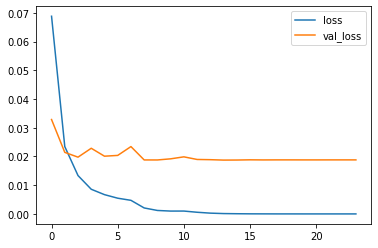

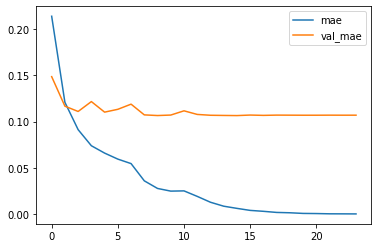

In [22]:
plt.plot(model.history.history["loss"], label="loss");
plt.plot(model.history.history["val_loss"], label="val_loss");
plt.legend();
plt.show();
plt.close();

plt.plot(model.history.history["mae"], label="mae");
plt.plot(model.history.history["val_mae"], label="val_mae");
plt.legend();

## [Use Transfer Learning](https://www.analyticsvidhya.com/blog/2020/03/pretrained-word-embeddings-nlp/)

In [23]:
# load the whole embedding into memory
embeddings_index = dict()

with open("/content/drive/My Drive/Colab Notebooks/glove.6B/glove.6B.300d.txt") as f:

    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [0]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((size_of_vocabulary, 300))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [25]:
model2=Sequential()

#embedding layer
model2.add(Embedding(size_of_vocabulary,
                    300,
                    weights=[embedding_matrix],
                    input_length=max_length,
                    trainable=False)) 

#lstm layer
model2.add(LSTM(128, activation='tanh',
               recurrent_activation="sigmoid", 
               recurrent_dropout=0,
               return_sequences=True))

#Global Maxpooling
model2.add(GlobalMaxPooling1D())

#Dense Layer
model2.add(Dense(64,activation='relu')) 
model2.add(Dense(1,activation='relu')) 

model2.compile(optimizer="RMSprop", loss='mean_squared_error', metrics=["mae"]) 

#Print summary of model
print(model2.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 382, 300)          8969700   
_________________________________________________________________
lstm_2 (LSTM)                (None, 382, 128)          219648    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 9,197,669
Trainable params: 227,969
Non-trainable params: 8,969,700
_________________________________________________________________
None


In [26]:
history = model2.fit(np.array(x_tr_seq),
                    np.array(y_tr),
                    batch_size=128,
                    epochs=1000,
                    validation_data=(np.array(x_val_seq),np.array(y_val)),
                    verbose=1,
                    callbacks=callbacks)

Train on 4652 samples, validate on 1164 samples
Epoch 1/1000
4652/4652 [==============================] - 36s 8ms/step - loss: 0.0834 - mae: 0.2114 - val_loss: 0.0298 - val_mae: 0.1429
Epoch 2/1000
4652/4652 [==============================] - 35s 7ms/step - loss: 0.0340 - mae: 0.1480 - val_loss: 0.0256 - val_mae: 0.1283
Epoch 3/1000
4652/4652 [==============================] - 35s 8ms/step - loss: 0.0255 - mae: 0.1264 - val_loss: 0.0282 - val_mae: 0.1347
Epoch 4/1000
4652/4652 [==============================] - 35s 7ms/step - loss: 0.0226 - mae: 0.1190 - val_loss: 0.0240 - val_mae: 0.1231
Epoch 5/1000
4652/4652 [==============================] - 35s 8ms/step - loss: 0.0189 - mae: 0.1100 - val_loss: 0.0224 - val_mae: 0.1195
Epoch 6/1000
4652/4652 [==============================] - 34s 7ms/step - loss: 0.0157 - mae: 0.0994 - val_loss: 0.0237 - val_mae: 0.1235
Epoch 7/1000
4652/4652 [==============================] - 34s 7ms/step - loss: 0.0139 - mae: 0.0941 - val_loss: 0.0366 - val_mae: 

In [27]:
#evaluation 
_, val_mae = model2.evaluate(x_val_seq, y_val)

print("The val_mae is %.3f." % val_mae)

1164/1164 [==============================] - 3s 2ms/step
The val_mae is 0.110.


In [0]:
model2.save('/content/drive/My Drive/final_project/lstm_plot_transfer_model_scaled')

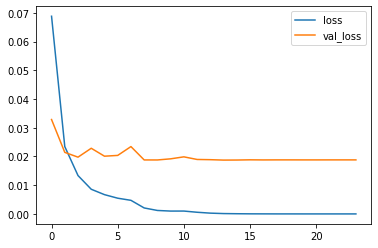

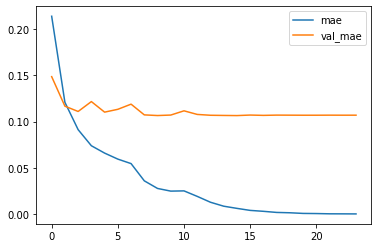

In [30]:
plt.plot(model.history.history["loss"], label="loss");
plt.plot(model.history.history["val_loss"], label="val_loss");
plt.legend();
plt.show();
plt.close();

plt.plot(model.history.history["mae"], label="mae");
plt.plot(model.history.history["val_mae"], label="val_mae");
plt.legend();

In [44]:
model2.predict(x_val_seq)

1164